In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import data
import uncertainty_estimation as ue
from main_bayesian import getModel
import config_bayesian as cfg
import utils
import torch


/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Load data
_, testset, inputs, num_classes = data.getDataset('MNIST')

ckpt_name = 'model_3conv3fc_lrt_relu_2023-10-05'

# Load model
ckpt = f'/home/marisa/Documents/PyTorch-BayesianCNN/checkpoints/MNIST/bayesian/{ckpt_name}.pt'
layer_type = cfg.layer_type
activation_type = cfg.activation_type

net = getModel('3conv3fc', inputs, num_classes, priors=None, layer_type=layer_type, activation_type=activation_type)
net.load_state_dict(torch.load(ckpt)["model_state_dict"])
net.train() # should this be train or eval?
net.to(device)


BBB3Conv3FC(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BBBConv2d()
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): BBBConv2d()
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): FlattenLayer()
  (fc1): BBBLinear()
  (act4): ReLU()
  (fc2): BBBLinear()
  (act5): ReLU()
  (fc3): BBBLinear()
)

### Calculate the uncertainties
* has the shape 10000 x 7
* for each of the 10000 test images it has the following values (in this order)
    * epistemic uncertainty (normalized)
    * aleatoric uncertainty (normalized)
    * epistemic uncertainty (softmax)
    * aleatoric uncertainty (softmax)
    * if the prediction was correct
    * true label 
    * predicted label

In [4]:
def evaluate_uncertainties(model):

    n_samples = len(testset)
    
    uncertainties = []

    for idx in range(n_samples):
        sample, truth = testset[idx]
        sample = sample.to(device)

        pred, epi_norm, ale_norm = ue.get_uncertainty_per_image(net, sample, T=25, normalized=True)
        pred, epi_soft, ale_soft = ue.get_uncertainty_per_image(net, sample, T=25, normalized=False)

        pred = int(np.argmax(pred))
        uncertainties.append([epi_norm[pred], ale_norm[pred], epi_soft[pred], ale_soft[pred], truth==pred, truth, pred])


    return uncertainties


In [5]:
uncertainties = evaluate_uncertainties(net)

### Data inspection 
Look at the data with PCA and t-SNE

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


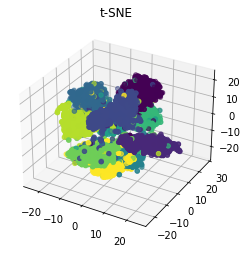

In [6]:
# t-SNE with 3 components (use PCA to reduce the dimensionality of the data first), color by label
pca = PCA(n_components=30)
pca_result = pca.fit_transform(testset.data.numpy().reshape(-1, 28*28))
tsne = TSNE(n_components=3)
tsne_result = tsne.fit_transform(pca_result)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=[i[0] for i in tsne_result], ys=[i[1] for i in tsne_result], zs=[i[2] for i in tsne_result], c=[i[5] for i in uncertainties])
plt.title('t-SNE')
plt.show()


In [7]:
# count how many right and wrng predictions there are for each class
right = [0 for i in range(10)]
wrong = [0 for i in range(10)]
for i in uncertainties:
    if i[4]:
        right[int(i[5])] += 1
    else:
        wrong[int(i[5])] += 1

for i in range(10):
    print('Class', i, ' - ', 'Right:', right[i], ' , ', 'Wrong:', wrong[i])


Class 0  -  Right: 978  ,  Wrong: 2
Class 1  -  Right: 1134  ,  Wrong: 1
Class 2  -  Right: 1025  ,  Wrong: 7
Class 3  -  Right: 1006  ,  Wrong: 4
Class 4  -  Right: 964  ,  Wrong: 18
Class 5  -  Right: 884  ,  Wrong: 8
Class 6  -  Right: 952  ,  Wrong: 6
Class 7  -  Right: 1021  ,  Wrong: 7
Class 8  -  Right: 965  ,  Wrong: 9
Class 9  -  Right: 1001  ,  Wrong: 8


In [8]:
# check range of uncertainties
print('Epistemic Uncertainty (Normalized):', min([i[0] for i in uncertainties]), max([i[0] for i in uncertainties]))
print('Aleatoric Uncertainty (Normalized):', min([i[1] for i in uncertainties]), max([i[1] for i in uncertainties]))
print('Epistemic Uncertainty (Softmax):', min([i[2] for i in uncertainties]), max([i[2] for i in uncertainties]))
print('Aleatoric Uncertainty (Softmax):', min([i[3] for i in uncertainties]), max([i[3] for i in uncertainties]))

Epistemic Uncertainty (Normalized): 0.00079017086 0.05895478
Aleatoric Uncertainty (Normalized): 0.041324615 0.2434563
Epistemic Uncertainty (Softmax): 0.0 0.18305303
Aleatoric Uncertainty (Softmax): 0.0 0.19434392


In [9]:
# make a threshold based on epistemic uncertainty (normalized)
t0 = min([i[0] for i in uncertainties])
t5 = max([i[0] for i in uncertainties])
steps = (t5-t0) / 5

t1 = t0 + steps
t2 = t1 + steps
t3 = t2 + steps
t4 = t3 + steps

In [10]:
# split the testset into 5 groups based on epistemic uncertainty (normalized)
testset0 = []
testset1 = []
testset2 = []
testset3 = []
testset4 = []
labels0 = []
labels1 = []
labels2 = []
labels3 = []
labels4 = []

for i, elem in enumerate(uncertainties):
    if elem[0] < t1:
        testset0.append(testset.data.numpy().reshape(-1, 28*28)[i])
        labels0.append(elem[5])
    elif elem[0] < t2:
        testset1.append(testset.data.numpy().reshape(-1, 28*28)[i])
        labels1.append(elem[5])
    elif elem[0] < t3:
        testset2.append(testset.data.numpy().reshape(-1, 28*28)[i])
        labels2.append(elem[5])
    elif elem[0] < t4:
        testset3.append(testset.data.numpy().reshape(-1, 28*28)[i])
        labels3.append(elem[5])
    else:
        testset4.append(testset.data.numpy().reshape(-1, 28*28)[i])
        labels4.append(elem[5])



/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


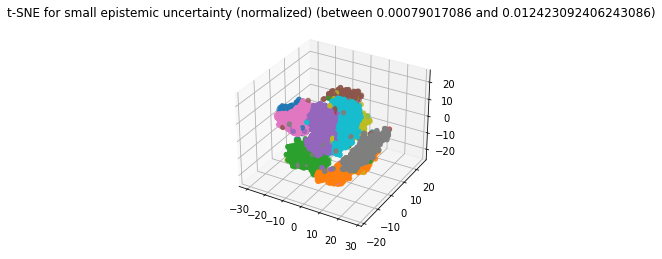

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


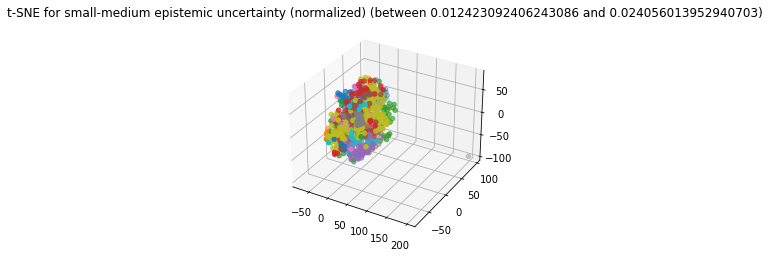

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


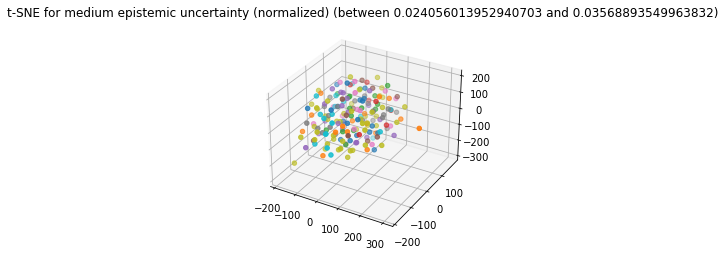

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


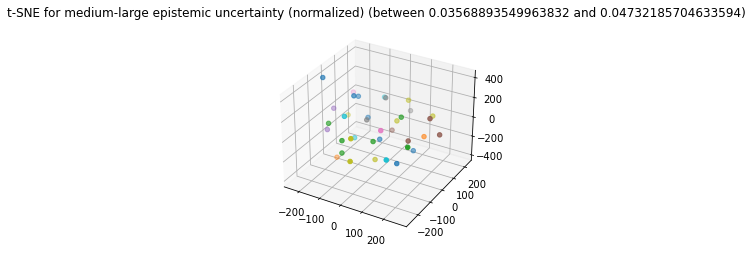

/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


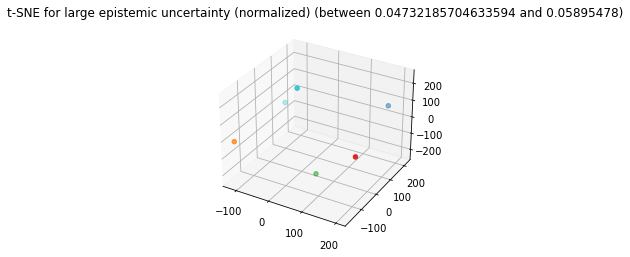

In [11]:
# t-SNE with 3 components (use PCA to reduce the dimensionality of the data first), color by label
testsets = [testset0, testset1, testset2, testset3, testset4]
thresholds = [t0, t1, t2, t3, t4, t5]
labelssets = [labels0, labels1, labels2, labels3, labels4]
vals = ["small", "small-medium", "medium", "medium-large", "large"]
for i in range(5):
    set_i = testsets[i]
    labels_i = labelssets[i]
    if len(labels_i) < 30:
        n_components = len(labels_i)
    else:
        n_components = 30
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(set_i)
    tsne = TSNE(n_components=3)
    tsne_result = tsne.fit_transform(pca_result)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=[i[0] for i in tsne_result], ys=[i[1] for i in tsne_result], zs=[i[2] for i in tsne_result], c=labels_i, cmap='tab10')
    plt.title('t-SNE for ' + vals[i] + ' epistemic uncertainty (normalized) (between ' + str(thresholds[i]) + ' and ' + str(thresholds[i+1]) + ')')
    plt.show()